# Import

In [1]:
import numpy as np
import time
import matplotlib
import itertools
# matplotlib.use("Agg")
import h5py
import matplotlib.pyplot as plt
import cv2
from skimage.morphology import skeletonize

import matplotlib.animation as animation
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import math
from scipy import interpolate
from scipy import integrate
import os

import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%matplotlib notebook

# Import data needed

In [24]:
file_paths = ["./two_fish_skeleton_data/FishTank20200130_153857_tracks_A.h5"]
original_instances = []
for file_path in file_paths:
    with h5py.File(file_path, 'r') as f:
        original_instances.append(np.copy(f['tracks_imCoords_raw']))

In [23]:
def threshold_maker(img):
    #threshold filters
    kernel = np.ones((3,3), np.uint8)
    erosed = cv2.erode(img, kernel, iterations=2) 
    blurred = cv2.GaussianBlur(erosed,(3,3),cv2.BORDER_DEFAULT)
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    round_frame = np.around(dilated[:,:,0]/255,1)
    dilated[round_frame > -0.1] = np.nan
    ret,thresh = cv2.threshold(dilated,0,1,cv2.THRESH_BINARY_INV)
    
    return thresh[:,:,0]

def distance(x1,y1,x2,y2):
    d = np.sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))
    return d

def all_distances(x,y):
    distances=[]
    for i in range(len(y)):
        dist = [distance(x[i],y[i],x[j],y[j]) for j in range(len(y))]
        distances.append(dist)
    return distances

def next_step(routes, distances, route_i):
    '''
    recursive function to find different routes
    '''
    
    if route_i >= len(routes):
        return routes, route_i
    else:
        
        if len(routes[route_i]) == 1:
            max_val = 20
        else:
            max_val = 1.5
        
        val = routes[route_i][-1]
        min_val = 0
        next_val = [i for i, j in enumerate(distances[val]) if j < max_val and i not in list(itertools.chain(*routes))]

        while next_val == [] and min_val < max_val:
            min_val = min([i for i in distances[val] if i>min_val])
            next_val = [i for i, j in enumerate(distances[val]) if j == min_val and i not in list(itertools.chain(*routes))]
    
        if min_val>max_val:
            next_val = []
        
        if next_val == []:
            routes, route_i = next_step(routes, distances, route_i + 1)
        
        if route_i >= len(routes):
            return routes, route_i
        else:
            if len(next_val) > 1:
                for i in range(1, len(next_val)):
                    routes.append(routes[route_i] + [next_val[i]])

            routes[route_i].append(next_val[0])
            routes, route_i = next_step(routes, distances, route_i)

    return routes, route_i

def find_route(x,y,head):
    distances = all_distances(x,y)
    
    # find start closest to head
    start = np.argmin(np.array([distance(x[i],y[i],head[0],head[1]) for i in range(len(x))]))
    
    routes, _ = next_step([[start]], distances, 0)
    
    return routes
    
def parameters_eucl(k, dist):
    if k == 0:
        return 0
    else:
        return sum(dist[0:k])/sum(dist)

def select_route(routes,tailpoint):
    
    # remove if tail not in route
    while True:
        for i in range(len(routes)):
            if tailpoint not in routes[i]:
                routes.pop(i)
                break
        else:
            break
    
    min_val = np.argmin(np.array([len(i) for i in routes]))
    max_val = np.argmax(np.array([len(i) for i in routes]))
    
    while len(routes[max_val]) - len(routes[min_val]) > 20 and len(routes) > 1:
        min_disttail = abs(routes[min_val].index(tailpoint) - len(routes[min_val]))
        max_disttail = abs(routes[max_val].index(tailpoint) - len(routes[max_val]))
        if min_disttail > max_disttail:
            routes.pop(min_val)
        else:
            routes.pop(max_val)
        min_val = np.argmin(np.array([len(i) for i in routes]))
        max_val = np.argmax(np.array([len(i) for i in routes]))
        
    for i in range(len(routes)):
        routes[i] = routes[i][0:(routes[i].index(tailpoint))+10]

    # take shortest route ("the most straight")
    route1 = routes[min_val]
    
    # look for a second route that might go along the other end of the tailfin
    while route1[-1] == routes[min_val][-1] and len(routes) > 1:
        routes.pop(min_val)
        min_val = np.argmin(np.array([len(i) for i in routes]))
    
    # return route1 if no second route (!might improve here)
    if route1[-1] == routes[min_val][-1]:
        return [route1]
    else:
        counter = 0
        for i in reversed(routes[min_val]):
            counter += 1
            if i in route1:
                a = route1.index(i) + 2
                break
            if counter > 10:
                return [route1[:-2]]
            
    return [route1[:a]]
     
def interpolate_equally(x, y, N, bdypts, view):
    # sort dots from front to end
    head = bdypts[0]
    routes = find_route(x,y,head)
    rts = np.copy(routes)
    
    # select route by tail and length
    min_taildist = 100
    for i in range(len(x)):
        taildist = distance(x[i],y[i],bdypts[2][0],bdypts[2][1])
        if taildist < min_taildist:
            min_taildist = taildist
            tailpoint = i
    routeminlen = select_route(routes,tailpoint)
    route = routeminlen[0]
    
    # sort
    sorted_values = [[y[i] for i in route], [x[i] for i in route]]
    
    # distances with bodypoints
    distances_thorax = [distance(sorted_values[1][i], sorted_values[0][i], bdypts[1][0],
                                 bdypts[1][1]) for i in range(len(sorted_values[0]))]
    
    index_min_thoraxdist = distances_thorax.index(min(distances_thorax))
    
    distances_tail = [distance(sorted_values[1][i], sorted_values[0][i], bdypts[2][0],
                               bdypts[2][1]) for i in range(len(sorted_values[0]))]
    
    index_min_taildist = distances_tail.index(min(distances_tail))
    
    # calculate parameters and interpolate
    dist = [distance(sorted_values[1][i],sorted_values[0][i],sorted_values[1][i+1],
                     sorted_values[0][i+1]) for i in range(len(sorted_values[0])-1)]
    parameters = [parameters_eucl(i,dist) for i in range(len(sorted_values[0]))]
    
    # place of thorax and tail
    par_minth = parameters[index_min_thoraxdist]
    par_mintl = parameters[index_min_taildist]
    
    # "curvature"
    s_i = 10
    
    pnew = np.linspace(0, 1, num=1000, endpoint=True)
    tck_x = interpolate.splrep(parameters, sorted_values[1], s=s_i)
    f_x = interpolate.splev(pnew, tck_x, der=0)
    tck_y = interpolate.splrep(parameters, sorted_values[0], s=s_i)
    f_y = interpolate.splev(pnew, tck_y, der=0)
    dist2 = [distance(f_x[i],f_y[i],f_x[i+1],f_y[i+1]) for i in range(len(f_x)-1)]
    
    # now find equally spaced points on the interpolated curve
    total_len = sum(dist2)
    
    equal_x = [f_x[0]]
    equal_y = [f_y[0]]
    part_len = 0
    for i in range(len(pnew)-1):
        part_len += np.sqrt(math.pow(np.diff(f_x)[i],2)+math.pow(np.diff(f_y)[i],2))
        
        N_part = N-1
        factor = 1

        if part_len >= total_len*factor/(N_part):
            part_len = 0
            equal_x.append(f_x[i])
            equal_y.append(f_y[i])
    
        if len(equal_x) >= 20:
            print("stopped")
            break
            
    if len(equal_x) < 20:
        equal_x.append(f_x[i])
        equal_y.append(f_y[i])
        
    return equal_x, equal_y, [f_x,f_y,rts]

def average_background(video, vid_range=None):
    vidcap = cv2.VideoCapture(video)
    success,image = vidcap.read()
    count = 0
    sum_images = image * 0

    while success:
        
        if vid_range == None:
            sum_images = sum_images.__add__(image/255)
        elif count >= vid_range - 100 and count <= vid_range + 100:
            sum_images = sum_images.__add__(image/255)
        elif count > vid_range + 100:
            break
            
        count += 1
        success,image = vidcap.read()
        
    return sum_images/count*255

def get_spine_coords(image, index, thorax, num, count, original_instances, points):
    
    skeleton = skeletonize(threshold_maker(image))
    values = np.where(skeleton==True)
    tail = [original_instances[0][1][count][index][2][0]-thorax[0]+num, 
            original_instances[0][1][count][index][2][1]-thorax[1]+num]
    head = [original_instances[0][1][count][index][0][0]-thorax[0]+num, 
            original_instances[0][1][count][index][0][1]-thorax[1]+num]
    thorax_ = [num,num]
    valus = np.append(values[1], [head[0]])
    valus1 = np.append(values[0], [head[1]])
    values = [valus1, valus]

    xequal, yequal, rest = interpolate_equally(values[1],values[0],points,[head,thorax_,tail],1)

    return xequal, yequal

def data_gather_experiment(experiment, points, view, original_instances):
    '''
    Loops over videos, then over frames
    then gets spine coords for 2 fish and saves them
    
    INPUT:
    experiment: path to experiment videos
    points: number of points on spine (N)
    view: 1(xy)
    original_instances = original instances dataset
    '''
        
    videos = sorted([i for i in os.listdir(experiment) if ".mp4" in i and i[0] == 's'])
    t0 = time.time()
    count=0
    
    # loop over videos
    for video in videos:

        print(video)

        x1_list = []
        x2_list = []
        y1_list = []
        y2_list = []

        ti = time.time()

        # calculate background average
        background = average_background(experiment + video)

        vidcap = cv2.VideoCapture(experiment + video)
        success,image = vidcap.read()

        num = 75
        
        # loop over frames
        while success:

            thorax_1 = original_instances[0][view][count][0][1]
            thorax_2 = original_instances[0][view][count][1][1]
            image1 = image - background

            # fish 1
            if np.any(np.isnan(thorax_1)):
                x1_list.append([np.nan] * points)
                y1_list.append([np.nan] * points)
            else:
                img1 = (image1[int(thorax_1[1])-num:int(thorax_1[1])+num,int(thorax_1[0])-num:int(thorax_1[0])+num])
                try:
                    x1,y1 = get_spine_coords(img1, 0, thorax_1, num, count, original_instances, points)
                    x1_list.append(x1)
                    y1_list.append(y1)
                except:
                    x1_list.append([np.nan] * points)
                    y1_list.append([np.nan] * points)

            # fish 2
            if np.any(np.isnan(thorax_2)):
                x2_list.append([np.nan] * points)
                y2_list.append([np.nan] * points)
            else:
                img2 = (image1[int(thorax_2[1])-num:int(thorax_2[1])+num,int(thorax_2[0])-num:int(thorax_2[0])+num])
                try:
                    x2,y2 = get_spine_coords(img2, 1, thorax_2, num, count, original_instances, points)
                    x2_list.append(x2)
                    y2_list.append(y2)
                except:
                    x2_list.append([np.nan] * points)
                    y2_list.append([np.nan] * points)

            count += 1
            success,image = vidcap.read()

        print(time.time()-ti)
        
        # save as h5
        with h5py.File("./two_fish_skeleton_data/spine_output/spine2fish" + video.split('.')[0] + ".h5",
                       "w") as hf:
            hf.create_dataset('x1', data=x1_list)
            hf.create_dataset('x2', data=x2_list)
            hf.create_dataset('y1', data=y1_list)
            hf.create_dataset('y2', data=y2_list)

    print(time.time()-t0)
    
    return

# Run experiment

In [25]:
data_gather_experiment('./two_fish_skeleton_data/E_xy/', 20, 1, original_instances)

splitdata0009.mp4
525.4810116291046
splitdata0010.mp4
511.01115822792053
splitdata0011.mp4
537.0670409202576
splitdata0012.mp4
449.0441725254059
splitdata0013.mp4
503.4404420852661
splitdata0014.mp4
472.25035333633423
splitdata0015.mp4
572.9841346740723
splitdata0016.mp4
556.4401934146881
splitdata0017.mp4
514.6938846111298
splitdata0018.mp4
619.842033624649
splitdata0019.mp4
490.2911784648895
splitdata0020.mp4
609.6721720695496
splitdata0021.mp4
541.2785172462463
splitdata0022.mp4
601.1349167823792
splitdata0023.mp4
555.9146304130554
splitdata0024.mp4
583.9585502147675
splitdata0025.mp4
583.170648097992
splitdata0026.mp4
627.3509712219238
splitdata0027.mp4
624.9305205345154
splitdata0028.mp4
591.3812530040741
splitdata0029.mp4
579.1533932685852
splitdata0030.mp4
556.2081236839294
splitdata0031.mp4
651.3642799854279
splitdata0032.mp4
634.0587606430054
splitdata0033.mp4
651.3720214366913
splitdata0034.mp4
620.1682183742523
splitdata0035.mp4
685.0814471244812
splitdata0036.mp4
684.442267

## Test

In [5]:
# calculate background average
video_test_xy = './two_fish_skeleton_data/E_xy/splitdata0014.mp4'
background_xy = average_background(video_test_xy)

<IPython.core.display.Javascript object>


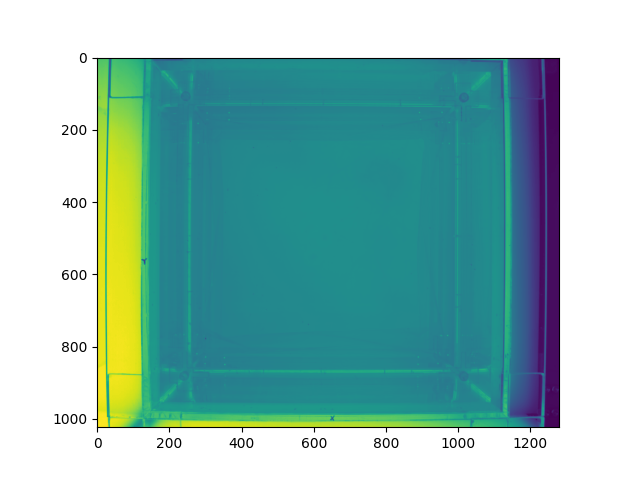

In [12]:
plt.figure()
plt.imshow(background[:,:,0])
plt.show()

In [6]:
def get_spine(image, index, thorax, ax):
    ax.cla()
    
    skeleton = skeletonize(threshold_maker(image))
    values = np.where(skeleton==True)
    tail = [original_instances[0][1][count][index][2][0]-thorax[0]+num, 
            original_instances[0][1][count][index][2][1]-thorax[1]+num]
    head = [original_instances[0][1][count][index][0][0]-thorax[0]+num, 
            original_instances[0][1][count][index][0][1]-thorax[1]+num]
    thorax_ = [num,num]
    valus = np.append(values[1], [head[0]])
    valus1 = np.append(values[0], [head[1]])
    values = [valus1, valus]
    
    ax.imshow(image[:,:,0],cmap='gray')
    ax.scatter(values[1],values[0],label='skeleton')
    ax.scatter(head[0],head[1],label='3-point model',c='yellow')
    ax.scatter(tail[0],tail[1],c='yellow')
    ax.scatter(thorax_[0],thorax_[1],c='yellow')
    
    if np.any(np.isnan([head,thorax_,tail])):
        return
    else:
        xequal, yequal, rest = interpolate_equally(values[1],values[0],20,[head,thorax_,tail],1)
        ax.scatter(xequal,yequal,c='red', label='interpolated spine')
        ax.plot(rest[0], rest[1],label='interpolated curve',c='white')
    return

<IPython.core.display.Javascript object>


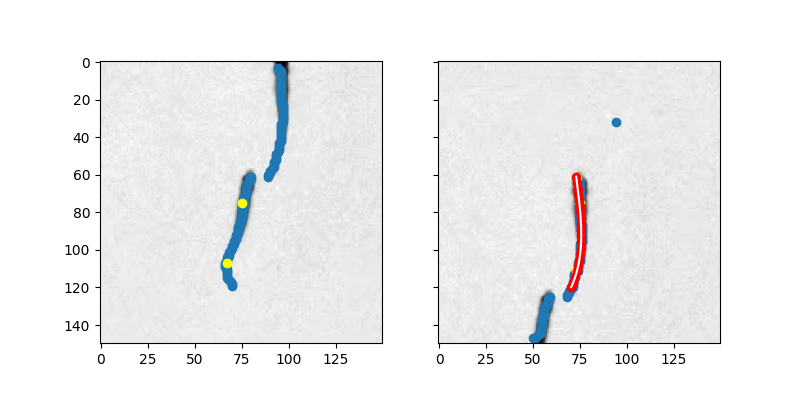

[808.10461426 360.934021  ] [829.92120361 296.99725342]


In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

frame = 0

num = 75

vidcap_1 = cv2.VideoCapture(video_test_xy)
succes1,image_1 = vidcap_1.read()
count = 0

while count < frame:
    count += 1
    succes1,image_1 = vidcap_1.read()

count += 4*6000
image1 = image_1 - background_xy

thorax_1 = original_instances[0][1][count][0][1]
if np.any(np.isnan(thorax_1)):
    print("missing data 1")
else:
    img1 = (image1[int(thorax_1[1])-num:int(thorax_1[1])+num,int(thorax_1[0])-num:int(thorax_1[0])+num])
    get_spine(img1, 0, thorax_1, ax1)

thorax_2 = original_instances[0][1][count][1][1]
if np.any(np.isnan(thorax_2)):
    print("missing data 2")
else:
    img2 = (image1[int(thorax_2[1])-num:int(thorax_2[1])+num,int(thorax_2[0])-num:int(thorax_2[0])+num])
    get_spine(img2, 1, thorax_2, ax2)

print(thorax_1, thorax_2)

In [ ]:
print(frame)